In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import preprocessing

In [2]:
def feature_generate_manually():
    train_path = '../data/hy_round1_train_20200102'
    test_path = '../data/hy_round1_testA_20200102'

    train_df_list = []
    for file_name in os.listdir(train_path):
        df = pd.read_csv(os.path.join(train_path, file_name))
        train_df_list.append(df)

    test_df_list = []
    for file_name in os.listdir(test_path):
        df = pd.read_csv(os.path.join(test_path, file_name))
        test_df_list.append(df)

    train_df = pd.concat(train_df_list)
    test_df = pd.concat(test_df_list)

    train_df['time'] = pd.to_datetime(train_df['time'], format='%m%d %H:%M:%S')
    test_df['time'] = pd.to_datetime(test_df['time'], format='%m%d %H:%M:%S')

    all_df = pd.concat([train_df, test_df], sort=False)

    new_df = all_df.groupby('渔船ID').agg(x_min=('x', 'min'), x_max=('x', 'max'), x_mean=('x', 'mean'), x_std=('x', 'std'), x_skew=('x', 'skew'), x_sum=('x', 'sum'),
                y_min=('y', 'min'), y_max=('y', 'max'), y_mean=('y', 'mean'), y_std=('y', 'std'), y_skew=('y', 'skew'), y_sum=('y', 'sum'),
                v_min=('速度', 'min'), v_max=('速度', 'max'), v_mean=('速度', 'mean'), v_std=('速度', 'std'), v_skew=('速度', 'skew'), v_sum=('速度', 'sum'),
                d_min=('方向', 'min'), d_max=('方向', 'max'), d_mean=('方向', 'mean'), d_std=('方向', 'std'), d_skew=('方向', 'skew'), d_sum=('方向', 'sum'))
    new_df['x_max-x_min'] = new_df['x_max'] - new_df['x_min']
    new_df['y_max-y_min'] = new_df['y_max'] - new_df['y_min']
    new_df['x_max-y_min'] = new_df['x_max'] - new_df['y_min']
    new_df['y_max-x_min'] = new_df['y_max'] - new_df['x_min']

    new_df['slope'] = new_df['y_max-y_min'] / np.where(new_df['x_max-x_min']==0, 0.001, new_df['x_max-x_min'])
    new_df['area'] = new_df['x_max-x_min'] * new_df['y_max-y_min']

    new_df['type'] = all_df.groupby('渔船ID').agg(type=('type', 'first'))['type'].values

    X_train = new_df.drop(columns=['type']).iloc[:7000]
    y_train = new_df.iloc[:7000]['type']

    X_test = new_df.drop(columns=['type']).iloc[7000:]

    return X_train, y_train, X_test


In [3]:
def feature_generate_tsfresh():
    train_df = pd.read_csv('./train_v5.csv')
    X_train = train_df.drop(columns=['type'])
    y_train = train_df['type']

    test_df = pd.read_csv('./test_v5.csv')
    X_test = test_df[X_train.columns]
    
    X_train_manully, _, X_test_manully = feature_generate_manually()

    X_train['x_max-x_min'] = X_train_manully['x_max-x_min'].values
    X_test['x_max-x_min'] = X_test_manully['x_max-x_min'].values
    X_train['x_max-y_min'] = X_train_manully['x_max-y_min'].values
    X_test['x_max-y_min'] = X_test_manully['x_max-y_min'].values
    X_train['y_max-x_min'] = X_train_manully['y_max-x_min'].values
    X_test['y_max-x_min'] = X_test_manully['y_max-x_min'].values
    X_train['y_max-y_min'] = X_train_manully['y_max-y_min'].values
    X_test['y_max-y_min'] = X_test_manully['y_max-y_min'].values

    X_train['slope'] = X_train_manully['slope'].values
    X_test['slope'] = X_test_manully['slope'].values
    X_train['area'] = X_train_manully['area'].values
    X_test['area'] = X_test_manully['area'].values

    base_model = lgb.LGBMClassifier(n_estimators=500, subsample=0.8)
    base_model.fit(X_train.values, y_train)

    selected_columns = X_train.columns[np.argsort(base_model.feature_importances_)[::-1][:200]]
    print(selected_columns)

    X_train = X_train[selected_columns]
    X_test = X_test[selected_columns]
    
    for column in list(X_test.columns[X_test.isnull().sum() > 0]):
        mean_val = X_test[column].mean()
        X_test[column].fillna(mean_val, inplace=True)

    return X_train.values, y_train.values, X_test.values

In [4]:
X_train_tsfresh, y_train_tsfresh, X_test_tsfresh = feature_generate_tsfresh()

Index(['y_max-x_min', 'x_max-y_min', 'x__quantile__q_0.1',
       'y__quantile__q_0.9', 'y__quantile__q_0.7', 'y__minimum',
       '速度__number_crossing_m__m_1', 'y__maximum', 'x__minimum',
       'dist__minimum',
       ...
       'x__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_5',
       'd__fft_coefficient__coeff_10__attr_"abs"',
       'y__ar_coefficient__k_10__coeff_4',
       '速度__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"stderr"',
       'y__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4',
       '速度__fft_coefficient__coeff_6__attr_"real"',
       'd_2__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6',
       'dist__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_2',
       'dist__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
       '速度__fft_coefficient__coeff_70__attr_"abs"'],
      dtype='object', length=200)


In [31]:
X_train = np.concatenate([X_train_tsfresh], axis=1)[:, :80]
X_test = np.concatenate([X_test_tsfresh], axis=1)[:, :80]

y_train = y_train_tsfresh

In [32]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [33]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [34]:
kf = KFold(5, shuffle=True, random_state=42)
for index, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    X_train_, X_valid, y_train_, y_valid = X_train[train_index], X_train[valid_index], y_train[train_index], y_train[valid_index]
    
    inputs = keras.Input(shape=(80,))
    x = keras.layers.Dense(512, activation='relu')(inputs)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    output = keras.layers.Dense(3, activation='softmax')(x)
    model = keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(x=X_train_, y=y_train_, validation_data=(X_valid, y_valid), batch_size=32, epochs=20, verbose=False)
    y_pred = model.predict(X_valid)
    y_valid = np.argmax(y_valid, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    valid_score = f1_score(y_valid, y_pred, average='macro')
    print(valid_score)

0.7622464289039379
0.720399835039463
0.7417325481020759
0.7573644772561942
0.7234758098995483


In [15]:
import os
import pandas as pd
import numpy as np

In [16]:
train_path = '../data/hy_round1_train_20200102'
test_path = '../data/hy_round1_testA_20200102'

train_df_list = []
for file_name in os.listdir(train_path):
    df = pd.read_csv(os.path.join(train_path, file_name))
    train_df_list.append(df)
    
test_df_list = []
for file_name in os.listdir(test_path):
    df = pd.read_csv(os.path.join(test_path, file_name))
    test_df_list.append(df)

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

train_df['time'] = pd.to_datetime(train_df['time'], format='%m%d %H:%M:%S')
test_df['time'] = pd.to_datetime(test_df['time'], format='%m%d %H:%M:%S')

all_df = pd.concat([train_df, test_df], sort=False)

In [17]:
train_x = []
test_x = []
train_y = []
test_y = []
for ship_id, group in all_df.groupby('渔船ID'):
    if int(ship_id) < 7000:
        train_x.append(np.mean(group['x'].values))
        train_y.append(np.mean(group['y'].values))
    else:
        test_x.append(np.mean(group['x'].values))
        test_y.append(np.mean(group['y'].values))

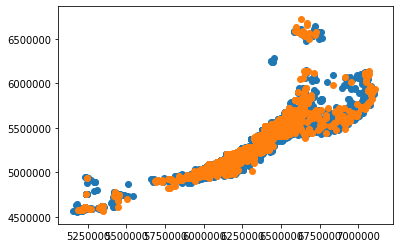

In [21]:
import matplotlib.pyplot as plt
plt.scatter(train_x, train_y)
plt.scatter(test_x, test_y)